In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
from prettytable import PrettyTable
import re
from sklearn import tree
from tqdm import tqdm
import pickle
from scipy import sparse

In [2]:
# loading df_train (cleaned data)
df_train = pd.read_csv('df_train.csv')


In [3]:
#droping Unnamed column
df_train.drop('Unnamed: 0',axis=1,inplace=True)
df_train.head(5)

,teacher_prefix,school_state,project_grade_category,project_subject_categories,project_subject_subcategories,teacher_number_of_previously_posted_projects,project_is_approved,quantity,price,preprocessed_titles,preprocessed_essays,preprocessed_resource_summary,number_present
0,mrs,in,grades_prek_2,literacy_language,esl_literacy,0,0,23,154.60,educational support english learners home,students english learners working english seco...,students need opportunities practice beginning...,0
1,mr,fl,grades_6_8,history_civics_health_sports,civics_government_teamsports,7,1,1,299.00,wanted projector hungry learners,students arrive school eager learn polite gene...,students need projector help viewing education...,0
2,ms,az,grades_6_8,health_sports,health_wellness_teamsports,1,0,22,516.85,soccer equipment awesome middle school students,true champions not always ones win guts mia ha...,students need shine guards athletic socks socc...,0
3,mrs,ky,grades_prek_2,literacy_language_math_science,literacy_mathematics,4,1,4,232.90,techie kindergarteners,work unique school filled esl english second l...,students need engage reading math way inspire ...,0
4,mrs,tx,grades_prek_2,math_science,mathematics,1,1,4,67.98,interactive math tools,second grade classroom next year made around 2...,students need hands practice mathematics fun p...,0


In [4]:
#checking for null value
df_train.isnull().sum()

teacher_prefix                                   0
school_state                                     0
project_grade_category                           0
project_subject_categories                       0
project_subject_subcategories                    0
teacher_number_of_previously_posted_projects     0
project_is_approved                              0
quantity                                         0
price                                            0
preprocessed_titles                             43
preprocessed_essays                              0
preprocessed_resource_summary                    0
number_present                                   0
dtype: int64

preprocessed_title have 43 NULL values, we will drop the null row 

In [5]:
#index of rows having null values in preprocessed_title column 
row_drop=df_train[df_train['preprocessed_titles'].isnull()==True].index
row_drop

Int64Index([   880,   3517,   7503,   9019,   9518,  12390,  15617,  17652,
             17798,  18915,  19122,  19731,  19772,  21484,  24024,  25089,
             29208,  32089,  32608,  34091,  41656,  41797,  45844,  50004,
             50526,  54464,  54781,  56857,  57432,  59766,  63032,  68453,
             68821,  73774,  74264,  77851,  80909,  81581,  93213,  94369,
            101144, 102430, 106760],
           dtype='int64')

In [6]:
print('Shape of df_train before drop ',df_train.shape)

# droping the row 
df_train.drop(row_drop,axis=0,inplace=True)

print('Shape of df_train after drop ',df_train.shape)

Shape of df_train before drop  (109248, 13)
Shape of df_train after drop  (109205, 13)


In [7]:
#checking of data is balanced or not
df_train['project_is_approved'].value_counts()

1    92680
0    16525
Name: project_is_approved, dtype: int64

- data is imbalanced

# Sentiment scores

In [8]:
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sid = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\rupes\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [9]:
Sentiment_neg=[]
Sentiment_pos=[]
Sentiment_neu=[]
Sentiment_comp=[]


for k in tqdm(df_train['preprocessed_essays']):
    ss=sid.polarity_scores(k)
    for i,j in [(Sentiment_neg,'neg'),(Sentiment_pos,'pos'),(Sentiment_neu,'neu'),(Sentiment_comp,'compound')]:
        i.append(ss[j])

100%|█████████████████████████████████████████████████████████████████████████| 109205/109205 [03:03<00:00, 594.07it/s]


In [10]:
df_train['Sentiment_neg']=Sentiment_neg
df_train['Sentiment_pos']=Sentiment_pos
df_train['Sentiment_neu']=Sentiment_neu
df_train['Sentiment_comp']=Sentiment_comp

In [11]:
df_train.head(2)

,teacher_prefix,school_state,project_grade_category,project_subject_categories,project_subject_subcategories,teacher_number_of_previously_posted_projects,project_is_approved,quantity,price,preprocessed_titles,preprocessed_essays,preprocessed_resource_summary,number_present,Sentiment_neg,Sentiment_pos,Sentiment_neu,Sentiment_comp
0,mrs,in,grades_prek_2,literacy_language,esl_literacy,0,0,23,154.6,educational support english learners home,students english learners working english seco...,students need opportunities practice beginning...,0,0.013,0.154,0.833,0.9694
1,mr,fl,grades_6_8,history_civics_health_sports,civics_government_teamsports,7,1,1,299.0,wanted projector hungry learners,students arrive school eager learn polite gene...,students need projector help viewing education...,0,0.052,0.305,0.643,0.9856


In [12]:
# creating dependent variable and independent varibale
X= df_train.drop('project_is_approved',axis=1)
Y=df_train['project_is_approved']

# splitting the data train , cross validation and test set 

In [13]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test =train_test_split(X, Y, test_size=0.33,stratify=Y)
X_train, X_cv, y_train, y_cv =train_test_split(X_train, y_train, test_size=0.33,stratify=y_train)


In [14]:
#storing the feature name created for getting top 20 feature name
feature_name=[]

## 4. One hot encoding for 'school_state'

In [15]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer()
vectorizer.fit(X_train['school_state'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_state_ohe = vectorizer.transform(X_train['school_state'].values)
X_cv_state_ohe = vectorizer.transform(X_cv['school_state'].values)
X_test_state_ohe = vectorizer.transform(X_test['school_state'].values)

print("After vectorizations")
print(X_train_state_ohe.shape, y_train.shape)
print(X_cv_state_ohe.shape, y_cv.shape)
print(X_test_state_ohe.shape, y_test.shape)
print(vectorizer.get_feature_names())
print("="*100)



#adding feature name to feature name list
feature_name.extend(vectorizer.get_feature_names())

After vectorizations
(49021, 51) (49021,)
(24146, 51) (24146,)
(36038, 51) (36038,)
['ak', 'al', 'ar', 'az', 'ca', 'co', 'ct', 'dc', 'de', 'fl', 'ga', 'hi', 'ia', 'id', 'il', 'in', 'ks', 'ky', 'la', 'ma', 'md', 'me', 'mi', 'mn', 'mo', 'ms', 'mt', 'nc', 'nd', 'ne', 'nh', 'nj', 'nm', 'nv', 'ny', 'oh', 'ok', 'or', 'pa', 'ri', 'sc', 'sd', 'tn', 'tx', 'ut', 'va', 'vt', 'wa', 'wi', 'wv', 'wy']


## 5. one hot encoding teacher_prefix

In [16]:
vectorizer = CountVectorizer()
vectorizer.fit(X_train['teacher_prefix'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_teacher_ohe = vectorizer.transform(X_train['teacher_prefix'].values)
X_cv_teacher_ohe = vectorizer.transform(X_cv['teacher_prefix'].values)
X_test_teacher_ohe = vectorizer.transform(X_test['teacher_prefix'].values)

print("After vectorizations")
print(X_train_teacher_ohe.shape, y_train.shape)
print(X_cv_teacher_ohe.shape, y_cv.shape)
print(X_test_teacher_ohe.shape, y_test.shape)
print(vectorizer.get_feature_names())
print("="*100)



#adding feature name to feature name list
feature_name.extend(vectorizer.get_feature_names())

After vectorizations
(49021, 5) (49021,)
(24146, 5) (24146,)
(36038, 5) (36038,)
['dr', 'mr', 'mrs', 'ms', 'teacher']


## 6. one hot encoding project_grade_category

In [17]:
vectorizer = CountVectorizer()
vectorizer.fit(X_train['project_grade_category'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_grade_ohe = vectorizer.transform(X_train['project_grade_category'].values)
X_cv_grade_ohe = vectorizer.transform(X_cv['project_grade_category'].values)
X_test_grade_ohe = vectorizer.transform(X_test['project_grade_category'].values)

print("After vectorizations")
print(X_train_grade_ohe.shape, y_train.shape)
print(X_cv_grade_ohe.shape, y_cv.shape)
print(X_test_grade_ohe.shape, y_test.shape)
print(vectorizer.get_feature_names())
print("="*100)



#adding feature name to feature name list
feature_name.extend(vectorizer.get_feature_names())

After vectorizations
(49021, 4) (49021,)
(24146, 4) (24146,)
(36038, 4) (36038,)
['grades_3_5', 'grades_6_8', 'grades_9_12', 'grades_prek_2']


## 7. one hot encoding project_subject_categories

In [18]:
vectorizer = CountVectorizer()
vectorizer.fit(X_train['project_subject_categories'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_categories_ohe = vectorizer.transform(X_train['project_subject_categories'].values)
X_cv_categories_ohe = vectorizer.transform(X_cv['project_subject_categories'].values)
X_test_categories_ohe = vectorizer.transform(X_test['project_subject_categories'].values)

print("After vectorizations")
print(X_train_categories_ohe.shape, y_train.shape)
print(X_cv_categories_ohe.shape, y_cv.shape)
print(X_test_categories_ohe.shape, y_test.shape)
print(vectorizer.get_feature_names())
print("="*100)




#adding feature name to feature name list
feature_name.extend(vectorizer.get_feature_names())


After vectorizations
(49021, 51) (49021,)
(24146, 51) (24146,)
(36038, 51) (36038,)
['appliedlearning', 'appliedlearning_health_sports', 'appliedlearning_history_civics', 'appliedlearning_literacy_language', 'appliedlearning_math_science', 'appliedlearning_music_arts', 'appliedlearning_specialneeds', 'appliedlearning_warmth_care_hunger', 'health_sports', 'health_sports_appliedlearning', 'health_sports_history_civics', 'health_sports_literacy_language', 'health_sports_math_science', 'health_sports_music_arts', 'health_sports_specialneeds', 'health_sports_warmth_care_hunger', 'history_civics', 'history_civics_appliedlearning', 'history_civics_health_sports', 'history_civics_literacy_language', 'history_civics_math_science', 'history_civics_music_arts', 'history_civics_specialneeds', 'history_civics_warmth_care_hunger', 'literacy_language', 'literacy_language_appliedlearning', 'literacy_language_health_sports', 'literacy_language_history_civics', 'literacy_language_math_science', 'literac

## 8. one hot encoding project_subject_subcategories

In [19]:
vectorizer = CountVectorizer()
vectorizer.fit(X_train['project_subject_subcategories'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_subcategories_ohe = vectorizer.transform(X_train['project_subject_subcategories'].values)
X_cv_subcategories_ohe = vectorizer.transform(X_cv['project_subject_subcategories'].values)
X_test_subcategories_ohe = vectorizer.transform(X_test['project_subject_subcategories'].values)

print("After vectorizations")
print(X_train_subcategories_ohe.shape, y_train.shape)
print(X_cv_subcategories_ohe.shape, y_cv.shape)
print(X_test_subcategories_ohe.shape, y_test.shape)
# print(vectorizer.get_feature_names())
print("="*100)



#adding feature name to feature name list
feature_name.extend(vectorizer.get_feature_names())

After vectorizations
(49021, 379) (49021,)
(24146, 379) (24146,)
(36038, 379) (36038,)


# SET 1 :TFIDF

# TFIDF of  preprocessed_essays

In [20]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(min_df=10,ngram_range=(1,4), max_features=5000)


#bag of word 
vectorizer.fit(X_train['preprocessed_essays'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_essay_tfidf = vectorizer.transform(X_train['preprocessed_essays'].values)
X_cv_essay_tfidf = vectorizer.transform(X_cv['preprocessed_essays'].values)
X_test_essay_tfidf = vectorizer.transform(X_test['preprocessed_essays'].values)

print("After vectorizations")
print(X_train_essay_tfidf.shape, y_train.shape)
print(X_cv_essay_tfidf.shape,y_cv.shape)
print(X_test_essay_tfidf.shape, y_test.shape)
print("="*100)


#adding feature name to feature name list
feature_name.extend(vectorizer.get_feature_names())

After vectorizations
(49021, 5000) (49021,)
(24146, 5000) (24146,)
(36038, 5000) (36038,)


# TFIDF of preprocessed_titles

In [21]:
vectorizer = TfidfVectorizer(min_df=10,ngram_range=(1,4), max_features=5000)
vectorizer.fit(X_train['preprocessed_titles'].values) #fitting on train set 

x_train_title_tfidf=vectorizer.transform(X_train['preprocessed_titles'].values) # transforming train set 
X_cv_title_tfidf=vectorizer.transform(X_cv['preprocessed_titles'].values)  # transforming cross validation set 
X_test_title_tfidf=vectorizer.transform(X_test['preprocessed_titles'].values) # transforming test test 


print(X_cv_title_tfidf.shape)
print(X_cv_title_tfidf.shape)
print(X_test_title_tfidf.shape)


#adding feature name to feature name list
feature_name.extend(vectorizer.get_feature_names())

(24146, 3447)
(24146, 3447)
(36038, 3447)


# TFIDF of preprocessed_resource_summary

In [22]:
vectorizer = TfidfVectorizer(min_df=10,ngram_range=(1,4), max_features=5000)

vectorizer.fit(X_train['preprocessed_resource_summary'].values) #fitting on train set 

x_train_summ_tfidf=vectorizer.transform(X_train['preprocessed_resource_summary'].values) # transforming train set 
X_cv_summ_tfidf=vectorizer.transform(X_cv['preprocessed_resource_summary'].values)  # transforming cross validation set 
X_test_summ_tfidf=vectorizer.transform(X_test['preprocessed_resource_summary'].values) # transforming test test 


print(X_cv_summ_tfidf.shape)
print(X_cv_summ_tfidf.shape)
print(X_test_summ_tfidf.shape)



#adding feature name to feature name list
feature_name.extend(vectorizer.get_feature_names())

(24146, 5000)
(24146, 5000)
(36038, 5000)


# Concatenating all the features

In [69]:

# merge two sparse matrices: https://stackoverflow.com/a/19710648/4084039
from scipy.sparse import hstack
X_tr = hstack((X_train_essay_tfidf,x_train_title_tfidf,x_train_summ_tfidf, X_train_state_ohe, X_train_teacher_ohe, X_train_grade_ohe,\
               X_train['price'].values.reshape(-1,1),\
               X_train['teacher_number_of_previously_posted_projects'].values.reshape(-1,1),\
               X_train['quantity'].values.reshape(-1,1),\
               X_train_subcategories_ohe,\
               X_train_categories_ohe,\
               X_train['Sentiment_neg'].values.reshape(-1,1),\
               X_train['Sentiment_pos'].values.reshape(-1,1),\
               X_train['Sentiment_neu'].values.reshape(-1,1),\
               X_train['Sentiment_comp'].values.reshape(-1,1),\
               X_train['number_present'].values.reshape(-1,1))).tocsr()


X_cr = hstack((X_cv_essay_tfidf,X_cv_title_tfidf,X_cv_summ_tfidf, X_cv_state_ohe, X_cv_teacher_ohe, X_cv_grade_ohe,\
               X_cv['price'].values.reshape(-1,1),\
               X_cv['teacher_number_of_previously_posted_projects'].values.reshape(-1,1),\
               X_cv['quantity'].values.reshape(-1,1),\
               X_cv_subcategories_ohe,\
               X_cv_categories_ohe,\
               X_cv['Sentiment_neg'].values.reshape(-1,1),\
               X_cv['Sentiment_pos'].values.reshape(-1,1),\
               X_cv['Sentiment_neu'].values.reshape(-1,1),\
               X_cv['Sentiment_comp'].values.reshape(-1,1),\
               X_cv['number_present'].values.reshape(-1,1))).tocsr()



X_te = hstack((X_test_essay_tfidf,X_test_title_tfidf,X_test_summ_tfidf, X_test_state_ohe, X_test_teacher_ohe, X_test_grade_ohe,\
               X_test['price'].values.reshape(-1,1),\
               X_test['teacher_number_of_previously_posted_projects'].values.reshape(-1,1),\
               X_test['quantity'].values.reshape(-1,1),\
               X_test_subcategories_ohe,\
               X_test_categories_ohe,\
               X_test['Sentiment_neg'].values.reshape(-1,1),\
               X_test['Sentiment_pos'].values.reshape(-1,1),\
               X_test['Sentiment_neu'].values.reshape(-1,1),\
               X_test['Sentiment_comp'].values.reshape(-1,1),\
               X_test['number_present'].values.reshape(-1,1))).tocsr()

print("Final Data matrix")
print(X_tr.shape, y_train.shape)
print(X_cr.shape, y_cv.shape)
print(X_te.shape, y_test.shape)
print("="*100)

Final Data matrix
(49021, 13945) (49021,)
(24146, 13945) (24146,)
(36038, 13945) (36038,)


# Hyperparameter tunning 

100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [05:25<00:00, 81.31s/it]


[Text(570.5454545454544, 0.5, 'min sample split'),
 Text(0.5, 24.0, 'max depth'),
 Text(0.5, 1.0, 'cv set')]

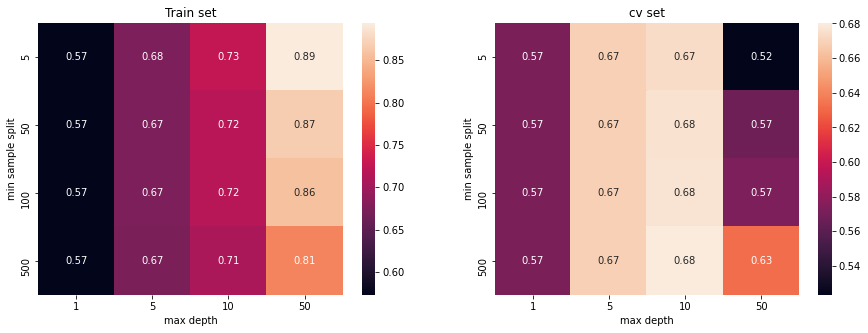

In [25]:
# grid search using simple for loop for different value of alpha[0.00001,0.0005, 0.0001,0.005,0.001,0.05,0.01,0.1,0.5,1,5,10,50,100]
# using multinomial naive bayes 
from sklearn.metrics import roc_auc_score
#list to store AUC score for different hyperparameter
train_auc = []
cv_auc = []

#parameters
max_depth= [1,5,10,50]
min_sample_split=[5,50,100,500]

for i in tqdm(max_depth):
    l_train=[]
    l_cv=[]
    for j in min_sample_split:
           
        clf = tree.DecisionTreeClassifier(criterion='gini',splitter='best',max_depth=i,min_samples_split=j,min_samples_leaf=2,)
        clf.fit(X_tr,y_train)

        #predicting the probability score for train and cross validate set 
        y_train_proba=clf.predict_proba(X_tr)
        y_CV_proba=clf.predict_proba(X_cr)

        #storing the hyperparameter
        
        l_train.append(roc_auc_score(y_train,y_train_proba[:,1]))
        l_cv.append(roc_auc_score(y_cv,y_CV_proba[:,1]))
        
    train_auc.append(l_train)
    cv_auc.append(l_cv)

arr_train=np.asarray(train_auc)
arr_cv=np.asarray(cv_auc)

fig,axes=plt.subplots(1,2,figsize=(15,5))
sns.heatmap(arr_train.T,xticklabels=max_depth,yticklabels=min_sample_split,annot=True,ax=axes[0],fmt='.4g').set(xlabel='max depth',ylabel='min sample split',title='Train set')
sns.heatmap(arr_cv.T,xticklabels=max_depth,yticklabels=min_sample_split,annot=True,ax=axes[1],fmt='.4g').set(xlabel='max depth',ylabel='min sample split',title='cv set')


- At max_depth= 10
- At min_sample_split =500

# Performing DecisionTree

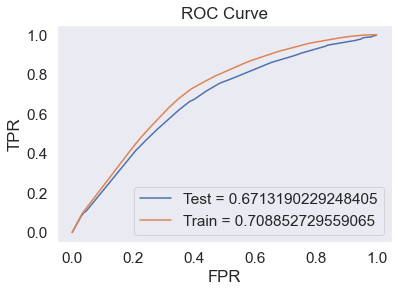

In [70]:
from sklearn import metrics
# for roc curve 

clf = clf = tree.DecisionTreeClassifier(criterion='gini',splitter='best',max_depth=10,min_samples_split=500,min_samples_leaf=2,)
clf.fit(X_tr,y_train)
    
#predicting the probability score for train and cross validate set 
y_test_proba=clf.predict_proba(X_te)
y_train_proba=clf.predict_proba(X_tr)
test_AUC_score_tfidf=roc_auc_score(y_test,y_test_proba[:,1])
train_AUC_score_tfidf=roc_auc_score(y_train,y_train_proba[:,1])
fpr, tpr, thresholds = metrics.roc_curve(y_test,y_test_proba[:,1], pos_label=1)
fpr1, tpr1, thresholds1 = metrics.roc_curve(y_train,y_train_proba[:,1], pos_label=1)

plt.plot(fpr,tpr,label='Test = '+str(test_AUC_score_tfidf))
plt.plot(fpr1,tpr1,label='Train = '+str(train_AUC_score_tfidf))
plt.legend()
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC Curve')
plt.grid()
plt.show()

# Confusion matrix

Text(0.5, 1.0, 'Cnfusion Matrix')

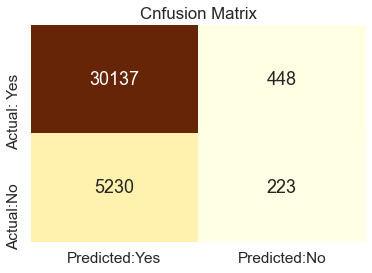

In [71]:
from sklearn.metrics import confusion_matrix

y_test_ped=clf.predict(X_te)
conf_matrix=confusion_matrix(y_test,y_test_ped,labels=[1,0])
con=pd.DataFrame(conf_matrix,index=['Actual: Yes',"Actual:No"],columns=['Predicted:Yes','Predicted:No'])
sns.set(font_scale=1.4)
sns.heatmap(con,annot=True,cmap="YlOrBr",cbar=False,fmt='g',annot_kws={"size": 18})
plt.title('Cnfusion Matrix')


# Word Cloud

In [72]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import pandas as pd

In [73]:
#combing y_test and y_test_predicted value to get false positive data
X_test['predited']=y_test_ped
X_test['project_is_approved']=y_test

<ipython-input-73-c68037a9b127>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-73-c68037a9b127>:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



100%|█████████████████████████████████████████████████████████████████████████████| 448/448 [00:00<00:00, 59540.80it/s]


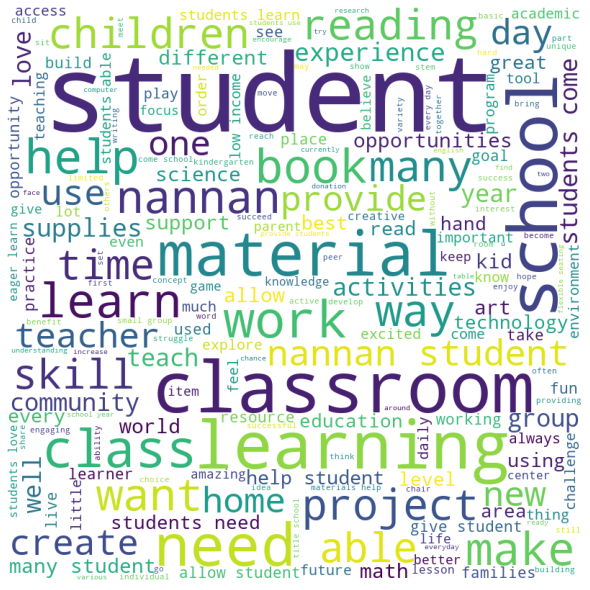

In [74]:
# code from GeekofGeeks (https://www.geeksforgeeks.org/generating-word-cloud-python/)
data=X_test[(X_test['project_is_approved']==1)& (X_test['predited']==0)]

total=''
for i in tqdm(data['preprocessed_essays']):
    total += ' '+i+' '

wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                min_font_size = 10).generate(total)

plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)

###  box plot with the price of these false positive data points

{'whiskers': [<matplotlib.lines.Line2D at 0x1861bad0a30>,
 'caps': [<matplotlib.lines.Line2D at 0x1861babf130>,
 'boxes': [<matplotlib.lines.Line2D at 0x1861bad06d0>],
 'medians': [<matplotlib.lines.Line2D at 0x1861babf7f0>],
 'fliers': [<matplotlib.lines.Line2D at 0x1861babfaf0>],
 'means': []}

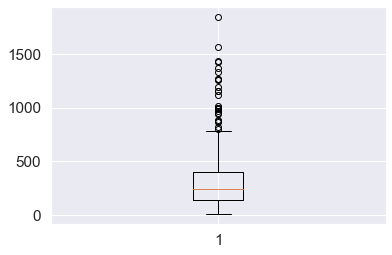

In [75]:
plt.boxplot(data['price'])

### pdf with the teacher_number_of_previously_posted_projects of these false positive data

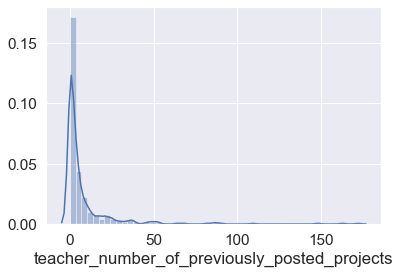

In [76]:
sns.distplot(data['teacher_number_of_previously_posted_projects'],kde=True)

- In False negative set most of teachers have Zero (0) or below 50 previously posted projects 

# TASK 2 - feature importance and selecting feature with non zero importance

Text(0.5, 1.0, 'Cnfusion Matrix')

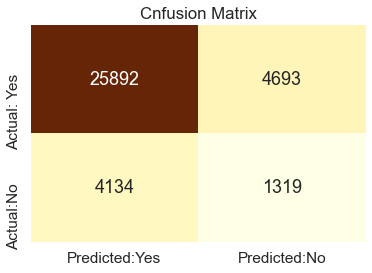

In [35]:
#running the decision tree to max depth
from sklearn.metrics import confusion_matrix
clf = clf = tree.DecisionTreeClassifier(criterion='gini',splitter='best',max_depth=None,min_samples_split=2,min_samples_leaf=2,)
clf.fit(X_tr,y_train)

y_test_ped=clf.predict(X_te)
conf_matrix=confusion_matrix(y_test,y_test_ped,labels=[1,0])
con=pd.DataFrame(conf_matrix,index=['Actual: Yes',"Actual:No"],columns=['Predicted:Yes','Predicted:No'])
sns.set(font_scale=1.4)
sns.heatmap(con,annot=True,cmap="YlOrBr",cbar=False,fmt='g',annot_kws={"size": 18})
plt.title('Cnfusion Matrix')

In [36]:
# feature importance 
important_feature=clf.feature_importances_

In [37]:
# storing indices on non zero features 
non_zero_feature=np.nonzero(important_feature)
non_zero_feature[0]

array([    2,    10,    14, ..., 13942, 13943, 13944], dtype=int64)

In [38]:
#print the shape before selection 
print(X_tr.shape)
print(X_cr.shape)
print(X_te.shape)


# storing non zero feature for train data set 
#creating the sparse matrix for train set by storing first two feature 
X_tr_new=hstack((X_tr[:,non_zero_feature[0][0]],X_tr[:,non_zero_feature[0][1]]))

for i in tqdm(non_zero_feature[0][2:]):
    X_tr_new=hstack((X_tr_new,X_tr[:,i]))
X_tr_new=X_tr_new.tocsr()
print(X_tr_new.shape)
    

# storing non zero feature for CV data set 
#creating the sparse matrix for CV set by storing first two feature 
X_cr_new=hstack((X_cr[:,non_zero_feature[0][0]],X_cr[:,non_zero_feature[0][1]]))

for i in tqdm(non_zero_feature[0][2:]):
    X_cr_new=hstack((X_cr_new,X_cr[:,i]))
X_cr_new=X_cr_new.tocsr()
print(X_cr_new.shape)


# storing non zero feature for test data set 
#creating the sparse matrix for test set by storing first two feature 
X_te_new=hstack((X_te[:,non_zero_feature[0][0]],X_te[:,non_zero_feature[0][1]]))

for i in tqdm(non_zero_feature[0][2:]):
    X_te_new=hstack((X_te_new,X_te[:,i]))
X_te_new=X_te_new.tocsr()
print(X_te_new.shape)   


  0%|▎                                                                                | 7/2164 [00:00<00:31, 68.94it/s]

(49021, 13945)
(24146, 13945)
(36038, 13945)


  1%|▍                                                                              | 12/2164 [00:00<00:19, 110.02it/s]

(49021, 2166)


  1%|▍                                                                              | 11/2164 [00:00<00:20, 104.32it/s]

(24146, 2166)


100%|██████████████████████████████████████████████████████████████████████████████| 2164/2164 [01:31<00:00, 23.62it/s]


(36038, 2166)


# Performing Decision tree on selected columns
### Hyperparameter tunning 

100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [03:11<00:00, 47.84s/it]


[Text(564.0454545454544, 0.5, 'min sample split'),
 Text(0.5, 17.5, 'max depth'),
 Text(0.5, 1.0, 'cv set')]

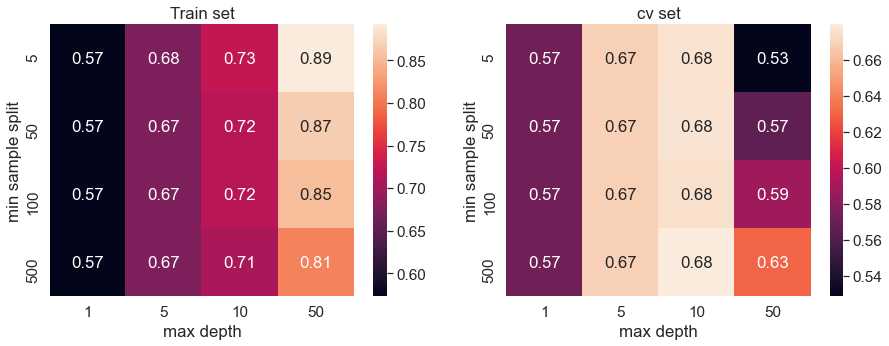

In [39]:
# performing Decision Tree model after removing columns with zero importance
# grid search using simple for loop for different value of alpha[0.00001,0.0005, 0.0001,0.005,0.001,0.05,0.01,0.1,0.5,1,5,10,50,100]

from sklearn.metrics import roc_auc_score
#list to store AUC score for different hyperparameter
train_auc = []
cv_auc = []

#parameters
max_depth= [1,5,10,50]
min_sample_split=[5,50,100,500]

for i in tqdm(max_depth):
    #list for storing the score of given depth i 
    l_train=[]
    l_cv=[]
    for j in min_sample_split:
           
        clf = tree.DecisionTreeClassifier(criterion='gini',splitter='best',max_depth=i,min_samples_split=j,min_samples_leaf=2,)
        clf.fit(X_tr_new,y_train)

        #predicting the probability score for train and cross validate set 
        y_train_proba=clf.predict_proba(X_tr_new)
        y_CV_proba=clf.predict_proba(X_cr_new)

        #storing the hyperparameter
        
        l_train.append(roc_auc_score(y_train,y_train_proba[:,1]))
        l_cv.append(roc_auc_score(y_cv,y_CV_proba[:,1]))
        
    train_auc.append(l_train)
    cv_auc.append(l_cv)

arr_train=np.asarray(train_auc)
arr_cv=np.asarray(cv_auc)

fig,axes=plt.subplots(1,2,figsize=(15,5))
sns.heatmap(arr_train.T,xticklabels=max_depth,yticklabels=min_sample_split,annot=True,ax=axes[0],fmt='.4g').set(xlabel='max depth',ylabel='min sample split',title='Train set')
sns.heatmap(arr_cv.T,xticklabels=max_depth,yticklabels=min_sample_split,annot=True,ax=axes[1],fmt='.4g').set(xlabel='max depth',ylabel='min sample split',title='cv set')


 Train and CV AUC score are close at max_depth =10 and min sample split=500 

# Performing DecisionTree 

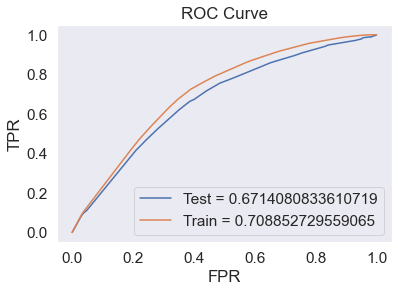

In [41]:
from sklearn import metrics
# for roc curve 

# using max_depth =5 and min sample split=50
clf = clf = tree.DecisionTreeClassifier(criterion='gini',splitter='best',max_depth=10,min_samples_split=500,min_samples_leaf=2,)
clf.fit(X_tr_new,y_train)
    
#predicting the probability score for train and cross validate set 
y_test_proba=clf.predict_proba(X_te_new)
y_train_proba=clf.predict_proba(X_tr_new)
test_AUC_score_tfidf2=roc_auc_score(y_test,y_test_proba[:,1])
train_AUC_score_tfidf=roc_auc_score(y_train,y_train_proba[:,1])
fpr, tpr, thresholds = metrics.roc_curve(y_test,y_test_proba[:,1], pos_label=1)
fpr1, tpr1, thresholds1 = metrics.roc_curve(y_train,y_train_proba[:,1], pos_label=1)


#plotting train and test AUC score graph
plt.plot(fpr,tpr,label='Test = '+str(test_AUC_score_tfidf2))
plt.plot(fpr1,tpr1,label='Train = '+str(train_AUC_score_tfidf))
plt.legend()
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC Curve')
plt.grid()
plt.show()

Text(0.5, 1.0, 'Cnfusion Matrix')

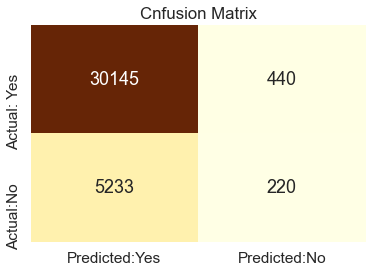

In [42]:
y_test_ped=clf.predict(X_te_new)
conf_matrix=confusion_matrix(y_test,y_test_ped,labels=[1,0])
con=pd.DataFrame(conf_matrix,index=['Actual: Yes',"Actual:No"],columns=['Predicted:Yes','Predicted:No'])
sns.set(font_scale=1.4)
sns.heatmap(con,annot=True,cmap="YlOrBr",cbar=False,fmt='g',annot_kws={"size": 18})
plt.title('Cnfusion Matrix')





# SET:2 TFIDF W2V

In [43]:
# stronging variables into pickle files python: http://www.jessicayung.com/how-to-use-pickle-to-save-and-load-variables-in-python/
# make sure you have the glove_vectors file
with open('glove_vectors', 'rb') as f:
    model = pickle.load(f)
    glove_words =  set(model.keys())

# TFIDF W2V preprocessed_essays


In [44]:
#creating tfidf vector on train data set
tfidf_model = TfidfVectorizer()
tfidf_model.fit(X_train['preprocessed_essays'].values)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(tfidf_model.get_feature_names(), list(tfidf_model.idf_)))
tfidf_words = set(tfidf_model.get_feature_names()) #creating the vocab

In [45]:

# average Word2Vec
# compute average word2vec for each review.
# for essay train data set
tfidf_w2v_vectors_train = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_train['preprocessed_essays'].values): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    tfidf_w2v_vectors_train.append(vector)

print(len(tfidf_w2v_vectors_train))
print(len(tfidf_w2v_vectors_train[0]))

100%|███████████████████████████████████████████████████████████████████████████| 49021/49021 [01:34<00:00, 518.16it/s]

49021
300


In [46]:
#for essay cv data set
# average Word2Vec
# compute average word2vec for each review.
tfidf_w2v_vectors_cv = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_cv['preprocessed_essays'].values): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    tfidf_w2v_vectors_cv.append(vector)

print(len(tfidf_w2v_vectors_cv))
print(len(tfidf_w2v_vectors_cv[0]))

100%|███████████████████████████████████████████████████████████████████████████| 24146/24146 [00:46<00:00, 520.86it/s]

24146
300


In [47]:
# for essay test data set
# average Word2Vec
# compute average word2vec for each review.
tfidf_w2v_vectors_test = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_test['preprocessed_essays'].values): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    tfidf_w2v_vectors_test.append(vector)

print(len(tfidf_w2v_vectors_test))
print(len(tfidf_w2v_vectors_test[0]))

100%|███████████████████████████████████████████████████████████████████████████| 36038/36038 [01:09<00:00, 519.69it/s]

36038
300


In [ ]:
df=

# TFIDF W2V TITLE

In [48]:

tfidf_model = TfidfVectorizer()
tfidf_model.fit(X_train['preprocessed_titles'].values)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(tfidf_model.get_feature_names(), list(tfidf_model.idf_)))
tfidf_words = set(tfidf_model.get_feature_names()) #creating the vocab

In [49]:
#creating list for storing the vectors 
tfidf_w2v_title_train=[]
tfidf_w2v_title_cv=[]
tfidf_w2v_title_test=[]



for i,j in [(tfidf_w2v_title_train,X_train),(tfidf_w2v_title_cv,X_cv),(tfidf_w2v_title_test,X_test)]:
    

     # the avg-w2v for each sentence/review is stored in this list
    for sentence in tqdm(j['preprocessed_titles'].values): # for each review/sentence
        vector = np.zeros(300) # as word vectors are of zero length
        tf_idf_weight =0; # num of words with a valid vector in the sentence/review
        for word in sentence.split(): # for each word in a review/sentence
            if (word in glove_words) and (word in tfidf_words):
                vec = model[word] # getting the vector for each word
                # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
                tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
                vector += (vec * tf_idf) # calculating tfidf weighted w2v
                tf_idf_weight += tf_idf
        if tf_idf_weight != 0:
            vector /= tf_idf_weight
        i.append(vector)

    print(len(i))
    print(len(i[0]))
    print('/n')

 18%|█████████████▏                                                            | 4289/24146 [00:00<00:00, 21858.13it/s]

49021
300
/n


  3%|██▍                                                                       | 1182/36038 [00:00<00:02, 11703.16it/s]

24146
300
/n


100%|█████████████████████████████████████████████████████████████████████████| 36038/36038 [00:01<00:00, 22712.18it/s]

36038
300
/n


# TFIDF W2V OF resource_summary

In [50]:

tfidf_model = TfidfVectorizer()
tfidf_model.fit(X_train['preprocessed_resource_summary'].values)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(tfidf_model.get_feature_names(), list(tfidf_model.idf_)))
tfidf_words = set(tfidf_model.get_feature_names()) #creating the vocab

In [51]:
tfidf_w2v_summ_train=[]
tfidf_w2v_summ_cv=[]
tfidf_w2v_summ_test=[]

for i,j in [(tfidf_w2v_summ_train,X_train),(tfidf_w2v_summ_cv,X_cv),(tfidf_w2v_summ_test,X_test)]:
    

     # the avg-w2v for each sentence/review is stored in this list
    for sentence in tqdm(j['preprocessed_resource_summary'].values): # for each review/sentence
        vector = np.zeros(300) # as word vectors are of zero length
        tf_idf_weight =0; # num of words with a valid vector in the sentence/review
        for word in sentence.split(): # for each word in a review/sentence
            if (word in glove_words) and (word in tfidf_words):
                vec = model[word] # getting the vector for each word
                # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
                tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
                vector += (vec * tf_idf) # calculating tfidf weighted w2v
                tf_idf_weight += tf_idf
        if tf_idf_weight != 0:
            vector /= tf_idf_weight
        i.append(vector)

    print(len(i))
    print(len(i[0]))
    print('\n')

 10%|███████▋                                                                  | 2511/24146 [00:00<00:01, 12372.13it/s]

49021
300




  6%|████▏                                                                     | 2020/36038 [00:00<00:03, 10189.49it/s]

24146
300




100%|█████████████████████████████████████████████████████████████████████████| 36038/36038 [00:03<00:00, 10515.51it/s]

36038
300




# Concatenating columns

In [52]:

# merge two sparse matrices: https://stackoverflow.com/a/19710648/4084039
from scipy.sparse import hstack
X_tr = hstack((sparse.csr_matrix(np.array(tfidf_w2v_vectors_train)),\
               sparse.csr_matrix(np.array(tfidf_w2v_title_train)),\
               sparse.csr_matrix(np.array(tfidf_w2v_summ_train)),\
               X_train_state_ohe,\
               X_train_teacher_ohe,\
               X_train_grade_ohe,\
               X_train['price'].values.reshape(-1,1),\
               X_train['teacher_number_of_previously_posted_projects'].values.reshape(-1,1),\
               X_train['quantity'].values.reshape(-1,1),\
               X_train_subcategories_ohe,\
               X_train_categories_ohe,\
               X_train['Sentiment_neg'].values.reshape(-1,1),\
               X_train['Sentiment_pos'].values.reshape(-1,1),\
               X_train['Sentiment_neu'].values.reshape(-1,1),\
               X_train['Sentiment_comp'].values.reshape(-1,1),\
               X_train['number_present'].values.reshape(-1,1))).tocsr()


X_cr = hstack((sparse.csr_matrix(np.array(tfidf_w2v_vectors_cv)),\
               sparse.csr_matrix(np.array(tfidf_w2v_title_cv)),\
               sparse.csr_matrix(np.array(tfidf_w2v_summ_cv)),\
               X_cv_state_ohe,\
               X_cv_teacher_ohe,\
               X_cv_grade_ohe,\
               X_cv['price'].values.reshape(-1,1),\
               X_cv['teacher_number_of_previously_posted_projects'].values.reshape(-1,1),\
               X_cv['quantity'].values.reshape(-1,1),\
               X_cv_subcategories_ohe,\
               X_cv_categories_ohe,\
               X_cv['Sentiment_neg'].values.reshape(-1,1),\
               X_cv['Sentiment_pos'].values.reshape(-1,1),\
               X_cv['Sentiment_neu'].values.reshape(-1,1),\
               X_cv['Sentiment_comp'].values.reshape(-1,1),\
               X_cv['number_present'].values.reshape(-1,1))).tocsr()



X_te = hstack((sparse.csr_matrix(np.array(tfidf_w2v_vectors_test)),\
               sparse.csr_matrix(np.array(tfidf_w2v_title_test)),\
               sparse.csr_matrix(np.array(tfidf_w2v_summ_test)),\
               X_test_state_ohe,\
               X_test_teacher_ohe,\
               X_test_grade_ohe,\
               X_test['price'].values.reshape(-1,1),\
               X_test['teacher_number_of_previously_posted_projects'].values.reshape(-1,1),\
               X_test['quantity'].values.reshape(-1,1),\
               X_test_subcategories_ohe,\
               X_test_categories_ohe,\
               X_test['Sentiment_neg'].values.reshape(-1,1),\
               X_test['Sentiment_pos'].values.reshape(-1,1),\
               X_test['Sentiment_neu'].values.reshape(-1,1),\
               X_test['Sentiment_comp'].values.reshape(-1,1),\
               X_test['number_present'].values.reshape(-1,1))).tocsr()

print("Final Data matrix")
print(X_tr.shape, y_train.shape)
print(X_cr.shape, y_cv.shape)
print(X_te.shape, y_test.shape)
print("="*100)

Final Data matrix
(49021, 1398) (49021,)
(24146, 1398) (24146,)
(36038, 1398) (36038,)


# Hyperparameter Tuning 

100%|███████████████████████████████████████████████████████████████████████████████████| 4/4 [32:12<00:00, 483.16s/it]


[Text(564.0454545454544, 0.5, 'min sample split'),
 Text(0.5, 17.5, 'max depth'),
 Text(0.5, 1.0, 'cv set')]

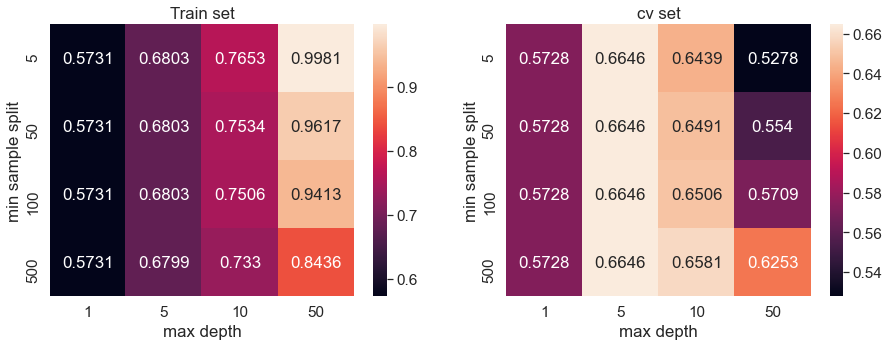

In [53]:
# grid search using simple for loop for different value of alpha[0.00001,0.0005, 0.0001,0.005,0.001,0.05,0.01,0.1,0.5,1,5,10,50,100]
# using multinomial naive bayes 
from sklearn.metrics import roc_auc_score
#list to store AUC score for different hyperparameter
train_auc = []
cv_auc = []

#parameters
max_depth= [1,5,10,50]
min_sample_split=[5,50,100,500]

for i in tqdm(max_depth):
    l_train=[]
    l_cv=[]
    for j in min_sample_split:
           
        clf = tree.DecisionTreeClassifier(criterion='gini',splitter='best',max_depth=i,min_samples_split=j,min_samples_leaf=2,)
        clf.fit(X_tr,y_train)

        #predicting the probability score for train and cross validate set 
        y_train_proba=clf.predict_proba(X_tr)
        y_CV_proba=clf.predict_proba(X_cr)

        #storing the hyperparameter
        
        l_train.append(roc_auc_score(y_train,y_train_proba[:,1]))
        l_cv.append(roc_auc_score(y_cv,y_CV_proba[:,1]))
        
    train_auc.append(l_train)
    cv_auc.append(l_cv)

arr_train=np.asarray(train_auc)
arr_cv=np.asarray(cv_auc)

fig,axes=plt.subplots(1,2,figsize=(15,5))
sns.heatmap(arr_train.T,xticklabels=max_depth,yticklabels=min_sample_split,annot=True,ax=axes[0],fmt='.6g').set(xlabel='max depth',ylabel='min sample split',title='Train set')
sns.heatmap(arr_cv.T,xticklabels=max_depth,yticklabels=min_sample_split,annot=True,ax=axes[1],fmt='.6g').set(xlabel='max depth',ylabel='min sample split',title='cv set')


## Heat map

- height AUC score on CV set is obtain for max_depth = 5 and min sample split =100 
- closest Train AUC score is 0.77 at  for max_depth = 5 and min sample split =100 

# Performing Decision Tree 

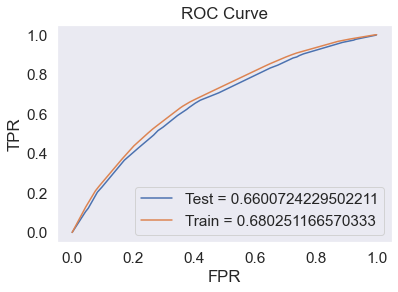

In [58]:
from sklearn import metrics
# for roc curve 


clf = clf = tree.DecisionTreeClassifier(criterion='gini',splitter='best',max_depth=5,min_samples_split=100,min_samples_leaf=2,)
clf.fit(X_tr,y_train)
    
#predicting the probability score for train and cross validate set 
y_test_proba=clf.predict_proba(X_te)
y_train_proba=clf.predict_proba(X_tr)
test_AUC_score_tfidf_w2v=roc_auc_score(y_test,y_test_proba[:,1])
train_AUC_score_tfidf=roc_auc_score(y_train,y_train_proba[:,1])
fpr, tpr, thresholds = metrics.roc_curve(y_test,y_test_proba[:,1], pos_label=1)
fpr1, tpr1, thresholds1 = metrics.roc_curve(y_train,y_train_proba[:,1], pos_label=1)

plt.plot(fpr,tpr,label='Test = '+str(test_AUC_score_tfidf_w2v))
plt.plot(fpr1,tpr1,label='Train = '+str(train_AUC_score_tfidf))
plt.legend()
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC Curve')
plt.grid()
plt.show()

# confusion matrix

Text(0.5, 1.0, 'Cnfusion Matrix')

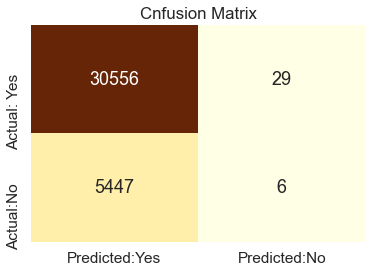

In [59]:
from sklearn.metrics import confusion_matrix

y_test_ped=clf.predict(X_te)
conf_matrix=confusion_matrix(y_test,y_test_ped,labels=[1,0])
con=pd.DataFrame(conf_matrix,index=['Actual: Yes',"Actual:No"],columns=['Predicted:Yes','Predicted:No'])
sns.set(font_scale=1.4)
sns.heatmap(con,annot=True,cmap="YlOrBr",cbar=False,fmt='g',annot_kws={"size": 18})
plt.title('Cnfusion Matrix')


# Word Cloud

<ipython-input-60-39aafa331ca2>:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-60-39aafa331ca2>:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

100%|███████████████████████████████████████████████████████████████████████████████| 29/29 [00:00<00:00, 39427.82it/s]


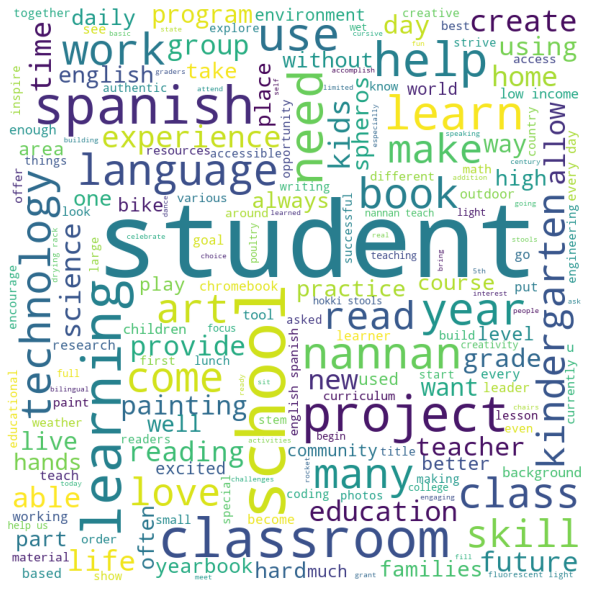

In [60]:
# Word Cloud

from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import pandas as pd

#combing y_test and y_test_predicted value to get false positive data
X_test['predited']=y_test_ped
X_test['project_is_approved']=y_test

#creating dataframe for flase positive
data=X_test[(X_test['project_is_approved']==1)& (X_test['predited']==0)]


# code from GeekforGeeks (https://www.geeksforgeeks.org/generating-word-cloud-python/)
total=''
for i in tqdm(data['preprocessed_essays']):
    total += ' '+i+' '

wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                min_font_size = 10).generate(total)

plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)


{'whiskers': [<matplotlib.lines.Line2D at 0x186110d0c10>,
 'caps': [<matplotlib.lines.Line2D at 0x186110c5310>,
 'boxes': [<matplotlib.lines.Line2D at 0x186110d08b0>],
 'medians': [<matplotlib.lines.Line2D at 0x186110c59d0>],
 'fliers': [<matplotlib.lines.Line2D at 0x186110c5cd0>],
 'means': []}

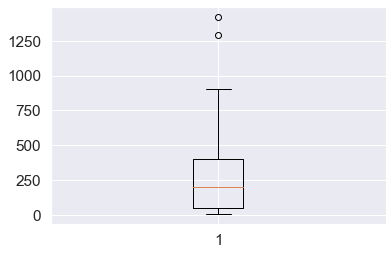

In [61]:
###  box plot with the price of these false positive data points

plt.boxplot(data['price'])

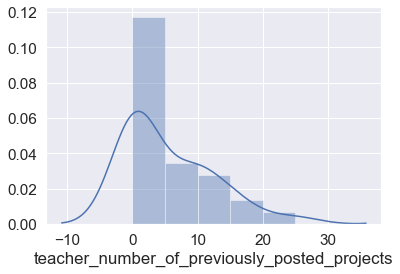

In [64]:
###  distribution plot with the price of these false positive data points

sns.distplot(data['teacher_number_of_previously_posted_projects'],kde=True)

# PrettyTable

In [77]:
# from prettytable import PrettyTable

from prettytable import PrettyTable

x = PrettyTable()
x.field_names = ["Vectorizer","Model", "MAX DEPTH","MIN SAMPLE SPLIT","AUC"]

x.add_row(['TFIDF','Decision Tree',10,50,test_AUC_score_tfidf])
x.add_row(['TFIDF on SELECTED COLUMN','Decision Tree',5,500,test_AUC_score_tfidf2])
x.add_row(['TFIDF AVG W2V','Decision Tree',5,100,test_AUC_score_tfidf_w2v])

print('Tabel')
print(x)

Tabel
+--------------------------+---------------+-----------+------------------+--------------------+
|        Vectorizer        |     Model     | MAX DEPTH | MIN SAMPLE SPLIT |        AUC         |
+--------------------------+---------------+-----------+------------------+--------------------+
|          TFIDF           | Decision Tree |     10    |        50        | 0.6713190229248405 |
| TFIDF on SELECTED COLUMN | Decision Tree |     5     |       500        | 0.6714080833610719 |
|      TFIDF AVG W2V       | Decision Tree |     5     |       100        | 0.6600724229502211 |
+--------------------------+---------------+-----------+------------------+--------------------+
